<a href="https://colab.research.google.com/github/dogTK/bioinfo-lecture/blob/colab/Rafael/AnnotateWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# git hub



# Do it with Python

## 説明

1. 5章で使用したファイルをgoogle driveにおいてAnnDataとして読み込む。
2. 遺伝子名が重複しているので、それを取り除く。
3. nCount, nFeature, mitochondria RNAの値でfilteringする。
> →violin plot
4. 正規化し、高変動遺伝子を見つける。
> この時点でのAnnDataを保存する。\
→CellTypistにはこれを使う。

### Annotationしない場合
5. 高変動遺伝子をスケーリング。その後、次元削減して可視化。

### CellTypistでAnnotation
5. celltypistのモデルをつくり、AnnDataを入力する。
6. その後、次元削減して可視化。


## install

In [ ]:
#Annotation
!pip install celltypist

In [ ]:
#umapに必要
!pip3 install igraph
!pip3 install leidenalg
!pip install python-igraph louvain

In [ ]:
#高変動遺伝子に必要
!pip install scikit-misc

In [ ]:
# 必要なパッケージのインストール
!pip install scanpy anndata

In [ ]:
# !pip install --upgrade anndata scanpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ライブラリのインポート
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

## data loading

In [ ]:
# Google Drive上のデータパスを指定
data_dir = '/content/drive/MyDrive/6 Internships/scRNAseq/最終課題'

# GSE149689
# data_dir = data_dir + "/" + "GSE149689"

# 139386
# data_dir = data_dir + "/" + "139386"

#section4のデータ
data_dir = data_dir + "/" + "hg19"
# data_dir = "/content/drive/MyDrive/6 Internships/scRNAseq/最終課題/hg19"

In [ ]:
# ファイルパスの指定
#
barcodes_path = f'{data_dir}/barcodes.tsv.gz'
features_path = f'{data_dir}/features.tsv.gz'
matrix_path = f'{data_dir}/matrix.mtx.gz'

In [ ]:
barcodes_path = f'{data_dir}/barcodes.tsv'
features_path = f'{data_dir}/features.tsv'
matrix_path = f'{data_dir}/matrix.mtx'

In [ ]:
# バーコード、特徴量、マトリックスの読み込み
barcodes = pd.read_csv(barcodes_path, header=None)
features = pd.read_csv(features_path, header=None, sep='\t')
matrix = scipy.io.mmread(matrix_path)
# AnnDataオブジェクトの作成
adata = sc.AnnData(X=matrix.T.tocsr())
adata.obs_names = barcodes[0].values #細胞名　obs.indexとおなじ
adata.var_names = features[1].values #遺伝子名 var.indexとおなじ

# 読み込んだデータの表示
print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738


### save current state

In [ ]:
# adata_copy1 = adata.copy()

In [ ]:
# adata = adata_copy1.copy()

## data exploration

In [ ]:
adata.var

In [ ]:
adata.obs

In [ ]:
print(adata.X)

## pre-processing

### 遺伝子の重複をなくす

同じ遺伝子が複数回adata.varに登録されている。\
重複している遺伝子については、発現量を全て合計して、その合計値で記録し、重複を消去する。

In [ ]:
# 重複している遺伝子名を見つける
duplicated_genes = adata.var_names[adata.var_names.duplicated()]
print("Duplicated genes:")
print(duplicated_genes)

In [ ]:
# 重複する遺伝子名のリストを取得
gene_names = adata.var_names.to_series()
duplicated_genes = gene_names[gene_names.duplicated(keep=False)]
print(duplicated_genes.shape)

In [ ]:
new_data = adata.to_df()
new_data = new_data.groupby(new_data.columns, axis=1).sum() #遺伝子ごとの発現量の合計値を計算する。

<ipython-input-13-6f246a8b3be9>:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  new_data = new_data.groupby(new_data.columns, axis=1).sum() #遺伝子ごとの発現量の合計値を計算する。


In [ ]:
adata =  sc.AnnData(X=new_data.values)
adata.obs_names = new_data.index
adata.var_names = new_data.columns

### QC

In [ ]:
# MT-で始まる遺伝子のインデックスを見つける
mt_genes = adata.var_names.str.startswith('MT-')

In [ ]:
print(type(mt_genes))
mt_genes

In [ ]:
def QC(adata):
    # MT-で始まる遺伝子のインデックスを見つける
    mt_genes = adata.var_names.str.startswith('MT-')
    # ミトコンドリア遺伝子の発現割合を計算してobsに追加
    percent_mt = adata[:,mt_genes].X.sum(axis=1) / adata.X.sum(axis=1) * 100
    # 各細胞におけるユニークな遺伝子の数（非ゼロの遺伝子数）
    nFeature_RNA = (adata.X > 0).sum(axis=1)
    # 各細胞における全てのRNA分子の総数
    nCount_RNA = adata.X.sum(axis=1)

    df_violin_QC =\
    pd.DataFrame({"nFeature_RNA":nFeature_RNA, "nCount_RNA":nCount_RNA, "percent_mt":percent_mt},\
                index = adata.obs_names)
    return df_violin_QC

In [ ]:
df_violin_QC = QC(adata)
violin_adata = sc.AnnData(df_violin_QC)

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


#### Violin plot & 相関 before QC

In [ ]:
# プロット1: バイオリンプロット
sc.pl.violin(violin_adata, ["nFeature_RNA", "nCount_RNA", "percent_mt"], jitter=0.4, multi_panel=True)

In [ ]:
corr_nCount_percent_mt = np.corrcoef(df_violin_QC['nCount_RNA'], df_violin_QC['percent_mt'])[0,1]
corr_nCount_nFeature_RNA = np.corrcoef(df_violin_QC['nCount_RNA'], df_violin_QC['nFeature_RNA'])[0, 1]

In [ ]:
# プロット2: 散布図
sc.pl.scatter(violin_adata, x='nCount_RNA', y='percent_mt', title=f'nCount_RNA vs percent_mt (corr: {corr_nCount_percent_mt:.2f})')
sc.pl.scatter(violin_adata, x='nCount_RNA', y='nFeature_RNA', title=f'nCount_RNA vs nFeature_RNA (corr: {corr_nCount_nFeature_RNA:.2f})')

#### Filtering

In [ ]:
adata_QC = adata[(200< df_violin_QC['nFeature_RNA'])\
                 & (df_violin_QC['nFeature_RNA'] < 5000)\
                 & (df_violin_QC['percent_mt'] < 15)]
print(adata)
print(adata_QC)

AnnData object with n_obs × n_vars = 2700 × 32643
View of AnnData object with n_obs × n_vars = 2698 × 32643


#### Violin plot & 相関 After QC

In [ ]:
# プロットの再表示 (フィルタリング後のデータに対して)
df_violin_QC = QC(adata_QC)
violin_adata = sc.AnnData(df_violin_QC)

sc.pl.violin(violin_adata, ["nFeature_RNA", "nCount_RNA", "percent_mt"], jitter=0.4, multi_panel=True)

corr_nCount_percent_mt = np.corrcoef(df_violin_QC['nCount_RNA'], df_violin_QC['percent_mt'])[0,1]
corr_nCount_nFeature_RNA = np.corrcoef(df_violin_QC['nCount_RNA'], df_violin_QC['nFeature_RNA'])[0, 1]

# プロット2: 散布図
sc.pl.scatter(violin_adata, x='nCount_RNA', y='percent_mt', title=f'nCount_RNA vs percent_mt (corr: {corr_nCount_percent_mt:.2f})')
sc.pl.scatter(violin_adata, x='nCount_RNA', y='nFeature_RNA', title=f'nCount_RNA vs nFeature_RNA (corr: {corr_nCount_nFeature_RNA:.2f})')

#### 正規化

In [ ]:
# 正規化
sc.pp.normalize_total(adata_QC, target_sum=1e4)
sc.pp.log1p(adata_QC) # celltypistはlog1pで変換されていることが前提になっている。

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### 変動遺伝子

In [ ]:
# 高可変性遺伝子の検出
sc.pp.highly_variable_genes(adata_QC, flavor='seurat_v3', n_top_genes=2000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [ ]:
# 上位10個の高変動遺伝子を取得
top10 = adata_QC.var[adata_QC.var['highly_variable']].sort_values(by='highly_variable_rank').index[:10]

# プロットの作成
plt.figure(figsize=(10, 6))
ax = sc.pl.highly_variable_genes(adata_QC, show=False)

# 上位10個の遺伝子にラベルを付ける
for gene in top10:
    idx = adata_QC.var.index.get_loc(gene)
    ax.annotate(gene, (adata_QC.var['means'][idx], adata_QC.var['variances'][idx]),
                fontsize=7, color='red', ha='right')

plt.show()

In [ ]:
# 高変動遺伝子のマスクを作成
highly_variable_mask = adata_QC.var['highly_variable']
# 高変動遺伝子のみをスケーリング
adata_highly_variable = adata_QC[:, highly_variable_mask].copy()
sc.pp.scale(adata_highly_variable)

#### 次元削減前のデータを保存

annotate後に再び次元削減して可視化する。

In [ ]:
# スケーリング前のデータを保存
adata_QC.layers['before_DimRed'] = adata_QC.X.copy()

#### スケーリング

In [ ]:
# スケーリングされた高変動遺伝子のデータを元のデータに戻す
adata_QC[:, highly_variable_mask].X = adata_highly_variable.X

### 次元削減

In [ ]:
# PCAの実行
sc.tl.pca(adata_QC,svd_solver='arpack')

# UMAPの実行
sc.pp.neighbors(adata_QC, n_pcs=20)  # UMAPの前に隣接グラフを作成する必要があります
sc.tl.umap(adata_QC)

# 隣接グラフの構築
sc.pp.neighbors(adata_QC, n_pcs=10)

In [ ]:
adata_QC.layers["before clustering"] = adata_QC.copy()
# adata_QC = adata_QC.layers["before clustering"].copy()

<ipython-input-25-415699c4653c>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_QC, resolution=0.5)


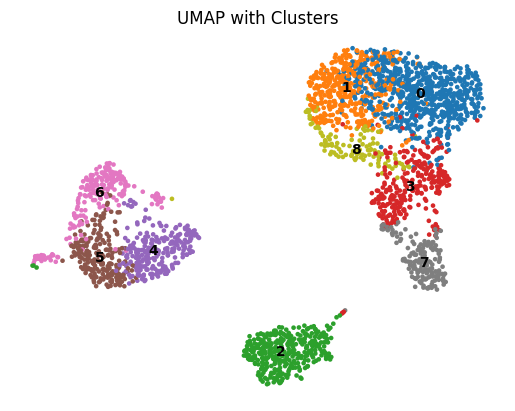

In [ ]:
# クラスタリングの実行
sc.tl.leiden(adata_QC, resolution=0.5)
# UMAPプロットの作成
sc.pl.umap(adata_QC, color='leiden', legend_loc='on data', title='UMAP with Clusters', frameon=False)

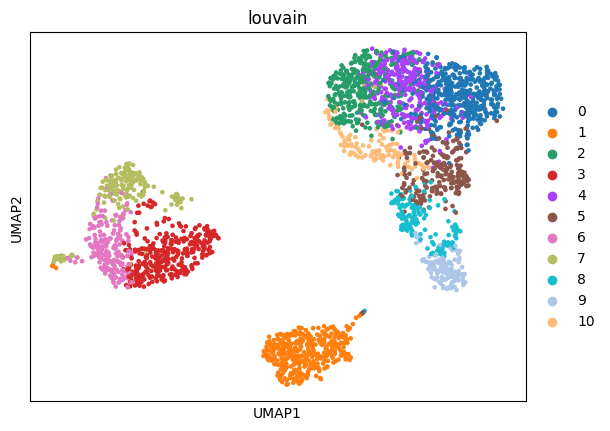

In [ ]:
# Louvainアルゴリズムによるクラスタリング
sc.tl.louvain(adata_QC)
sc.pl.umap(adata_QC, color=['louvain'])

#### save current state

In [ ]:
adata_clustered = adata_QC.copy()

In [ ]:
# adata_copy = adata.copy()

# annotation

In [ ]:
adata_CellTypist= adata_QC.copy()
adata_CellTypist.X = adata_QC.layers['before_DimRed'].copy()

In [ ]:
# adata = adata_copy.copy()

In [ ]:
total_counts = np.expm1(adata_CellTypist.X).sum(axis=1)
print(total_counts)
print(total_counts.min(), total_counts.max())

## CellTypist

In [ ]:
import celltypist
from celltypist import models

In [ ]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

In [ ]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')

# アノテーションの実行
predictions = celltypist.annotate(adata_CellTypist, model = 'Immune_All_Low.pkl', majority_voting = True)

# アノテーション結果の追加
#adata_CellTypist.obs['CellTypist_labels'] = predictions.predicted_labels
adata_CellTypist = predictions.to_adata()
# アノテーション結果の保存
# adata.write('annotated_data.h5ad')

In [ ]:
# adata_CellTypist = sc.read_h5ad('/content/annotated_data.h5ad')

In [ ]:
adata_CellTypist.obs

In [ ]:
adata_CellTypist

##### scaling

In [ ]:
adata_CellTypist.obs

In [ ]:
# スケーリングされた高変動遺伝子のデータを元のデータに戻す
adata_CellTypist[:, highly_variable_mask].X = adata_highly_variable.X

#### 次元削減

In [ ]:
# PCAの実行
sc.tl.pca(adata_CellTypist,svd_solver='arpack')

# UMAPの実行
sc.pp.neighbors(adata_CellTypist, n_pcs=20)  # UMAPの前に隣接グラフを作成する必要があります
sc.tl.umap(adata_CellTypist)

# 隣接グラフの構築
sc.pp.neighbors(adata_CellTypist, n_pcs=10)

In [ ]:
adata_CellTypist.layers["annotate before clustering"] = adata_CellTypist.copy()
# adata_QC = adata_QC.layers["annotate before clustering"].copy()

In [ ]:
# クラスタリングの実行
sc.tl.leiden(adata_CellTypist, resolution=0.5)
# UMAPプロットの作成
# sc.pl.umap(adata_CellTypist, color='predicted_labels', legend_loc='on data', title='UMAP with Annotations', frameon=False)

sc.pl.umap(adata_CellTypist, color='predicted_labels', title='Annotation by CellTypist', frameon=False)

In [ ]:
adata_CellTypist.obs['predicted_labels'].value_counts()

In [ ]:
# 100以上の出現回数を持つ細胞タイプを取得
cell_type_counts = adata_CellTypist.obs['predicted_labels'].value_counts()
frequent_cell_types = cell_type_counts[cell_type_counts >= 70].index.tolist()
# UMAPプロット
sc.pl.umap(adata_CellTypist,
           color='predicted_labels',
           title='Frequent Cell Types (Count >= 100) by CellTypist',
           frameon=False)

In [ ]:
# 100以上の出現回数を持つ細胞タイプを取得
cell_type_counts = adata_CellTypist.obs['predicted_labels'].value_counts()
frequent_cell_types = cell_type_counts[cell_type_counts >= 70].index.tolist()
rare_cell_types = cell_type_counts[(cell_type_counts < 70) & (cell_type_counts >= 5)].index.tolist()

# 頻出する細胞タイプのインデックスを取得
selected_indices = adata_CellTypist.obs['predicted_labels'].isin(frequent_cell_types)

# 新しいAnnDataオブジェクトを作成（選択された細胞タイプ）
adata_CellTypist_selected = sc.AnnData(
    X=adata_CellTypist.X[selected_indices],
    obs=adata_CellTypist.obs.loc[selected_indices],
    var=adata_CellTypist.var,
    uns=adata_CellTypist.uns.copy(),
    obsm={'X_umap': adata_CellTypist.obsm['X_umap'][selected_indices]},
    varm=adata_CellTypist.varm,
    layers={key: layer[selected_indices] for key, layer in adata_CellTypist.layers.items()},
    obsp={key: connectivities[selected_indices][:, selected_indices] for key, connectivities in adata_CellTypist.obsp.items()}
)

# predicted_labelsのカテゴリを選択された細胞タイプに限定
adata_CellTypist_selected.obs['predicted_labels'] = pd.Categorical(
    adata_CellTypist_selected.obs['predicted_labels'],
    categories=frequent_cell_types
)

# 稀な細胞タイプのインデックスを取得

rare_indices = adata_CellTypist.obs['predicted_labels'].isin(rare_cell_types)

# 新しいAnnDataオブジェクトを作成（稀な細胞タイプ）
adata_CellTypist_rare = sc.AnnData(
    X=adata_CellTypist.X[rare_indices],
    obs=adata_CellTypist.obs.loc[rare_indices],
    var=adata_CellTypist.var,
    uns=adata_CellTypist.uns.copy(),
    obsm={'X_umap': adata_CellTypist.obsm['X_umap'][rare_indices]},
    varm=adata_CellTypist.varm,
    layers={key: layer[rare_indices] for key, layer in adata_CellTypist.layers.items()},
    obsp={key: connectivities[rare_indices][:, rare_indices] for key, connectivities in adata_CellTypist.obsp.items()}
)

# predicted_labelsのカテゴリを稀な細胞タイプに限定
rare_cell_types = list(set(adata_CellTypist_rare.obs['predicted_labels'].unique()) - set(frequent_cell_types))
adata_CellTypist_rare.obs['predicted_labels'] = pd.Categorical(
    adata_CellTypist_rare.obs['predicted_labels'],
    categories=rare_cell_types
)

In [ ]:
# UMAPプロット
sc.pl.umap(adata_CellTypist_selected,
           color='predicted_labels',
           title = "common cells",
           frameon=False)

In [ ]:
# UMAPプロット
sc.pl.umap(adata_CellTypist_rare,
           color='predicted_labels',
           title = "Rare Cells",
           frameon=False)

In [ ]:
# プロットの設定
fig, ax = plt.subplots(figsize=(12, 10))

# adata_CellTypist_selectedをグレーで表示（キャプションなし）
sc.pl.umap(adata_CellTypist_selected,
           ax=ax,
           color='predicted_labels',
           palette=['lightgrey'] * len(adata_CellTypist_selected.obs['predicted_labels'].cat.categories),
           legend_loc=None,  # キャプションを非表示
           show=False,
           title='')

# adata_CellTypist_rareをcolor='predicted_labels'で表示（キャプション付き）
sc.pl.umap(adata_CellTypist_rare,
           ax=ax,
           color='predicted_labels',
        #    legend_loc='on data',  # キャプションをプロット内に表示
           legend_fontsize=8,
           legend_fontoutline=2,
           size=100,
           show=False,
           title='')
plt.tight_layout()
plt.show()

In [ ]:
# Louvainアルゴリズムによるクラスタリング
sc.tl.louvain(adata_CellTypist)
sc.pl.umap(adata_CellTypist, color='predicted_labels')

subclassを細かく分類しすぎているだけなのかも。 \
* 一番大きい島のT cell
* その付近にNK cell
* B cellの島 \
* monocytoの島 \
とみると、seuratによる分類とほぼ一致する。

Seuratの自動アノテーション

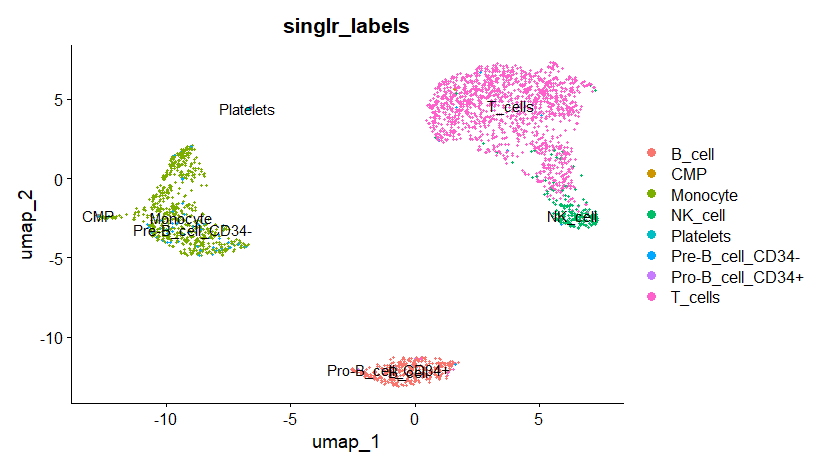

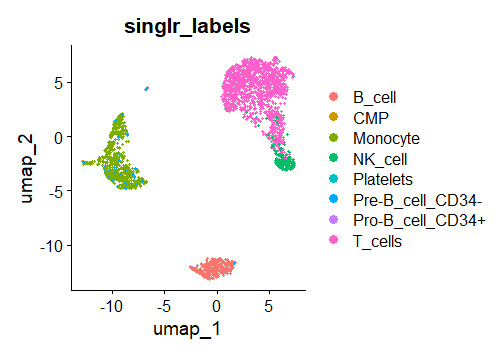

## decoupler

https://qiita.com/nikera/items/45cc4d6491182d1e0aab

In [ ]:
adata_decoupler = adata_clustered.copy()

In [ ]:
!pip install decoupler
!pip install omnipath

In [ ]:
import decoupler as dc

In [ ]:
markers = dc.get_resource('PanglaoDB')
markers

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [ ]:
# Load cell type markers
markers = dc.get_resource('PanglaoDB')
# markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

In [ ]:
# Perform ORA
dc.run_ora(mat=adata_decoupler, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

16026 features of mat are empty, they will be removed.
Running ora on mat with 2698 samples and 16617 targets for 164 sources.


100%|██████████| 2698/2698 [00:27<00:00, 99.65it/s] 


In [ ]:
# Extract activities
acts = dc.get_acts(adata_decoupler, obsm_key='ora_estimate')
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [ ]:
# Rank cell types for each cluster
df_decoupler = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')

In [ ]:
acts.var

""
source
Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway goblet cells
...
Trophoblast cells
Tuft cells
Undefined placental cells


,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T memory cells,21.383565,4.007429,6.155398e-88,1.009485e-85
1,0,rest,T helper cells,17.475913,0.641888,1.801980e-61,7.388117e-60
2,0,rest,T follicular helper cells,14.618028,0.399505,1.173670e-44,1.924819e-43
3,0,rest,T cells,14.052620,2.620811,7.143817e-42,9.012200e-41
4,0,rest,T cytotoxic cells,13.876045,0.731902,4.546358e-41,5.325734e-40
...,...,...,...,...,...,...,...
1471,8,rest,Langerhans cells,-6.279498,-1.211432,5.916203e-09,4.490522e-08
1472,8,rest,Monocytes,-6.289624,-3.585543,5.698960e-09,4.490522e-08
1473,8,rest,Erythroid-like and erythroid precursor cells,-6.393257,-0.477299,1.750609e-09,1.688823e-08
1474,8,rest,Microglia,-6.430277,-0.828033,2.164397e-09,1.868217e-08


In [ ]:
# Get top predicted cell type for each cluster
annotation_dict = df_decoupler.groupby('group').head(1).set_index('group')['names'].to_dict()

In [ ]:
# Annotate cells
adata_decoupler.obs['cell_type'] = [annotation_dict[clust] for clust in adata_decoupler.obs['leiden']]

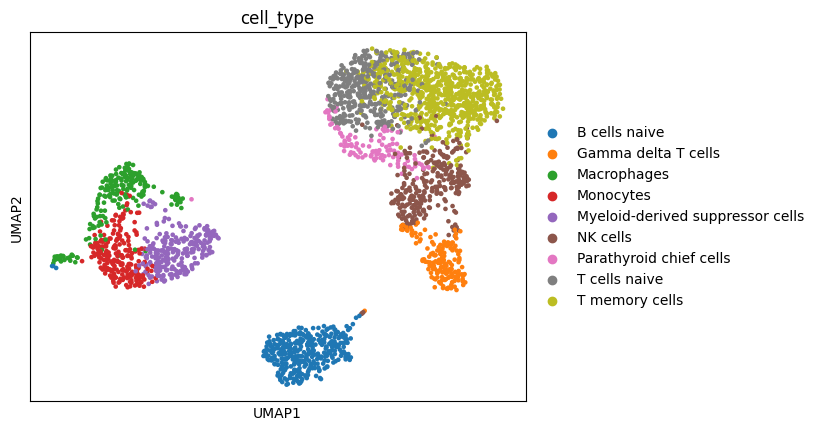

In [ ]:
# Visualize results
sc.pl.umap(adata_decoupler, color='cell_type')

## CellO

In [ ]:
adata_CellO=  adata_clustered.copy()

In [ ]:
# Graphvizの依存関係をインストール
!apt-get install -y graphviz graphviz-dev

In [ ]:
!pip install pygraphviz leidenalg scanpy cello-classify
!curl -O ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3516nnn/GSM3516673/suppl/GSM3516673_MSK_LX682_NORMAL_dense.csv.gz

In [ ]:
import cello
import os

In [ ]:
# cello.normalize_and_cluster(adata_CellO, n_pca_components=50, n_neighbors=15, n_top_genes=10000, cluster_res=2.0)

In [ ]:
# CellOのリソースの場所を指定
cello_resource_loc = os.getcwd()

In [ ]:
# クラスタリングと分類
model_prefix = 'GSM3516673_MSK_LX682_NORMAL'  # モデルのファイルプレフィックス
cello.scanpy_cello(
    adata_CellO,
    clust_key='leiden',  # カスタムクラスタリングを使用する場合はこの部分を変更
    rsrc_loc=cello_resource_loc,
    out_prefix=model_prefix,
    log_dir=os.getcwd()
)

In [ ]:
# UMAPの計算
sc.tl.umap(adata_CellO)

# UMAPプロットを作成（クラスターごとに色分け）
sc.pl.umap(adata_CellO, color='leiden', title='Clusters')

In [ ]:
# 最も特異な予測細胞型で色分けされたUMAPプロットを作成
sc.pl.umap(adata_CellO, color='Most specific cell type')

In [ ]:
# T細胞である確率に基づいて色分けされたUMAPプロットを作成
sc.pl.umap(adata_CellO, color='T cell (probability)', vmin=0.0, vmax=1.0)

In [ ]:
# T細胞であるかどうかに基づいて色分けされたUMAPプロットを作成
sc.pl.umap(adata_CellO, color='T cell (binary)')

## scBERT

In [ ]:
!git clone https://github.com/TencentAILabHealthcare/scBERT.git
!cd scBERT
!pip install -r requirements.txt

In [ ]:
import torch
from scBERT import scBERTModel, process_data

# 要検討

## scanpyのfillter

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)